In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

import df_visualizations as dv
import remap_values as rv

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn               import linear_model

In [2]:
%matplotlib inline
plt.style.use( 'dark_background' )
plt.rcParams['figure.figsize'] = (14,10)

In [3]:
use_list = ['parcelid',
    'logerror','transactiondate','airconditioningtypeid','pooltypeid10', # Hotub
    'poolsizesum','garagetotalsqft','calculatedbathnbr','fireplacecnt',
    'finishedsquarefeet12','lotsizesquarefeet','taxdelinquencyflag','yearbuilt',
    'structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount',
    'decktypeid','numberofstories','buildingqualitytypeid','unitcnt','roomcnt' ]

In [4]:
prop  = pd.read_csv( 'data/properties_2016.csv' )
trans = pd.read_csv( 'data/train_2016_v2.csv'   )

my_df = pd.merge( prop, trans, on='parcelid', how='inner' )
my_df = my_df[ use_list ]

del prop
del trans

my_df['transactiondate' ] =   pd.to_datetime  ( my_df['transactiondate'] )
my_df['time_since_built'] = ( pd.DatetimeIndex( my_df['transactiondate'] ).year - my_df['yearbuilt'] )
my_df['ordinal_date'    ] =  [x.toordinal() for x in my_df['transactiondate']]
my_df['day_of_week'     ] = ( my_df['ordinal_date'] - my_df['ordinal_date'].min() + 2 ) % 7

my_df = my_df.drop( ['yearbuilt'], axis=1 )

print my_df.shape

/home/sean/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(90275, 24)


In [15]:
my_df.columns.values

array(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'pooltypeid10', 'poolsizesum', 'garagetotalsqft',
       'calculatedbathnbr', 'fireplacecnt', 'finishedsquarefeet12',
       'lotsizesquarefeet', 'taxdelinquencyflag',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'decktypeid',
       'numberofstories', 'buildingqualitytypeid', 'unitcnt', 'roomcnt',
       'time_since_built', 'ordinal_date', 'day_of_week'], dtype=object)

In [5]:
# Only flag which units have AC

my_df['has_ac'] = 1

my_df.ix[ my_df['airconditioningtypeid'].isnull(), ['has_ac'] ] = 0
my_df.ix[ my_df['airconditioningtypeid'] == 5    , ['has_ac'] ] = 0

my_df = my_df.drop( 'airconditioningtypeid', axis=1 )




# Flag for has pool, has spa, size of pool

my_df['has_spa'  ] = 0
my_df['has_pool' ] = 0
my_df['pool_sqft'] = 0

my_df['has_spa'  ] = my_df['pooltypeid10'].fillna(0).astype(int)
my_df['pool_sqft'] = my_df['poolsizesum' ]
my_df['has_pool' ] =(my_df['poolsizesum' ] > 0).astype(int)

my_df = my_df.drop( ['pooltypeid10','poolsizesum'], axis=1 )




# Save the sqft in better variables

my_df['unit_sqft'] = my_df['finishedsquarefeet12']
my_df[ 'lot_sqft'] = my_df['lotsizesquarefeet'   ]

my_df = my_df.drop( ['finishedsquarefeet12', 'lotsizesquarefeet'], axis=1 )






# n_units, if nan most likely a single unit. 1/nan, 2, 3, 4, multi

my_df['unitcnt'].unique()

my_df['n_units_single'] = 0
my_df['n_units_double'] = 0
my_df['n_units_multi' ] = 0

my_df.ix[ my_df['unitcnt'].isnull() , 'n_units_single' ] = 1
my_df.ix[ my_df['unitcnt'] == 1     , 'n_units_single' ] = 1
my_df.ix[ my_df['unitcnt'] == 2     , 'n_units_double' ] = 1
my_df.ix[ my_df['unitcnt'] >  2     , 'n_units_multi'  ] = 1

my_df = my_df.drop( 'unitcnt', axis=1 )





# Flag for tax delinquency

my_df['tax_delinquent'] = my_df['taxdelinquencyflag'].fillna(0).replace( {'Y': 1} )

my_df = my_df.drop( 'taxdelinquencyflag', axis=1 )





# Break building quality into categories

my_df['building_quality_low' ] = 0
my_df['building_quality_med' ] = 0
my_df['building_quality_high'] = 0
my_df['building_quality_unkn'] = 0

my_df.ix[  my_df['buildingqualitytypeid'] < 4     , 'building_quality_high' ] = 1
my_df.ix[  my_df['buildingqualitytypeid'] > 8     , 'building_quality_low'  ] = 1
my_df.ix[ (my_df['buildingqualitytypeid'] > 3)    &
        (  my_df['buildingqualitytypeid'] < 9)    , 'building_quality_med'  ] = 1
my_df.ix[  my_df['buildingqualitytypeid'].isnull(), 'building_quality_unkn' ] = 1

my_df = my_df.drop( 'buildingqualitytypeid', axis=1 )





# Have flag for garage, and sqft variable

my_df['has_garage' ] = 0
my_df['garage_sqft'] = my_df['garagetotalsqft'].fillna(0)

my_df.ix[ my_df['garagetotalsqft']>1, 'has_garage' ] = 1

my_df = my_df.drop( 'garagetotalsqft', axis=1 )






# Break into single, multi-story flag

my_df['n_stories_single'] = 0
my_df['n_stories_multi' ] = 0
my_df['n_stories_unkn'  ] = 0

my_df.ix[ my_df['numberofstories'] == 1    , 'n_stories_single' ] = 1
my_df.ix[ my_df['numberofstories'] >  1    , 'n_stories_multi'  ] = 1
my_df.ix[ my_df['numberofstories'].isnull(), 'n_stories_unkn'   ] = 1


my_df = my_df.drop( 'numberofstories', axis=1 )






# 1 hot encode deck, var for number of fireplaces

my_df['n_fireplaces'] = my_df['fireplacecnt'].fillna(0)
my_df['has_deck'    ] = my_df['decktypeid'  ].notnull().astype(int)

my_df = my_df.drop( ['fireplacecnt','decktypeid'], axis=1 )

In [7]:
my_df.columns.values

array(['logerror', 'transactiondate', 'calculatedbathnbr',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'roomcnt', 'time_since_built',
       'ordinal_date', 'day_of_week', 'has_ac', 'has_spa', 'has_pool',
       'pool_sqft', 'unit_sqft', 'lot_sqft', 'n_units_single',
       'n_units_double', 'n_units_multi', 'tax_delinquent',
       'building_quality_low', 'building_quality_med',
       'building_quality_high', 'building_quality_unkn', 'has_garage',
       'garage_sqft', 'n_stories_single', 'n_stories_multi',
       'n_stories_unkn', 'n_fireplaces', 'has_deck'], dtype=object)

In [88]:
remain_list = ['calculatedbathnbr', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 
               'taxamount', 'numberofstories', 'roomcnt']

In [21]:
most_stuff = ['logerror', 'calculatedbathnbr',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'numberofstories', 'unitcnt',
       'roomcnt', 'time_since_built', 'ordinal_date', 'day_of_week',
       'has_ac', 'has_spa', 'has_pool', 'pool_sqft', 'unit_sqft',
       'lot_sqft', 'tax_delinquent', 'building_quality_low',
       'building_quality_med', 'building_quality_high',
       'building_quality_unkn', 'has_garage', 'garage_sqft',
       'n_fireplaces', 'has_deck']

In [89]:
my_df[remain_list].isnull().sum().sort_values()

roomcnt                           0
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             1
taxamount                         6
structuretaxvaluedollarcnt      380
calculatedbathnbr              1182
numberofstories               69705
dtype: int64

In [65]:
print my_df.ix[ my_df['taxvaluedollarcnt'].isnull(), ['taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'] ].head()
print my_df.ix[ my_df['taxamount'].isnull(), ['taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'] ].head()

       taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  \
22541                NaN                    NaN       51.4   

       structuretaxvaluedollarcnt  
22541                         NaN  
       taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  \
1305             42432.0                42432.0        NaN   
34947            68200.0                68200.0        NaN   
51225           179068.0                58912.0        NaN   
62405           224400.0               224400.0        NaN   
64316           104936.0                41227.0        NaN   

       structuretaxvaluedollarcnt  
1305                          NaN  
34947                         NaN  
51225                    120156.0  
62405                         NaN  
64316                     63709.0  


In [23]:
for item in remain_list:
    print item
    print my_df[most_stuff].corrwith( my_df[item] ).sort_values()
    print ' '

calculatedbathnbr
time_since_built             -0.369543
building_quality_med         -0.172283
tax_delinquent               -0.033956
ordinal_date                 -0.005578
lot_sqft                      0.004853
day_of_week                   0.017949
logerror                      0.029448
roomcnt                       0.031486
has_deck                      0.043949
building_quality_unkn         0.045206
has_spa                       0.057994
has_pool                      0.073455
n_fireplaces                  0.100314
has_garage                    0.118644
unitcnt                       0.154641
building_quality_high         0.171318
garage_sqft                   0.193996
has_ac                        0.225834
pool_sqft                     0.254296
building_quality_low          0.257078
numberofstories               0.369760
landtaxvaluedollarcnt         0.371634
taxamount                     0.487320
taxvaluedollarcnt             0.497763
structuretaxvaluedollarcnt    0.611665
unit_sq

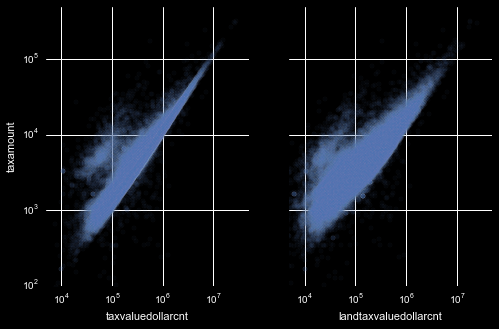

In [77]:
fig, axes = plt.subplots( 1, 2, figsize=(8,5) )

axes[0].set_xlim( [ 5e3 , 5e7 ] )
axes[1].set_xlim( [ 5e3 , 5e7 ] )

axes[0].set_ylim( [ 1e2 , 5e5 ] )
axes[1].set_ylim( [ 1e2 , 5e5 ] )


my_df.plot.scatter( x='taxvaluedollarcnt'    , y='taxamount', alpha=0.05, logx=True, logy=True, ax = axes[0] )
my_df.plot.scatter( x='landtaxvaluedollarcnt', y='taxamount', alpha=0.05, logx=True, logy=True, ax = axes[1] )

axes[1].set_yticklabels([])
axes[1].set_ylabel('')

Clearly taxvaluedollarcnt and landtaxvaluedollarcnt can be predicted by taxamount,

as well as the converse

[[ 1.22114937]]
[ 0.75806492]


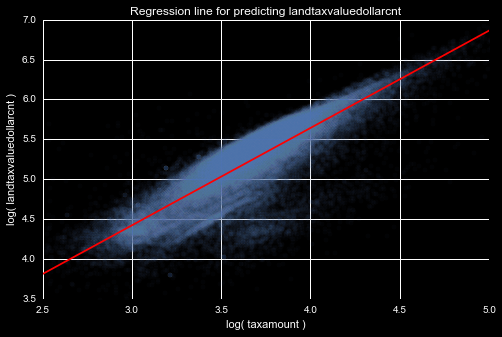

[[ 1.02053397]]
[ 1.7830499]


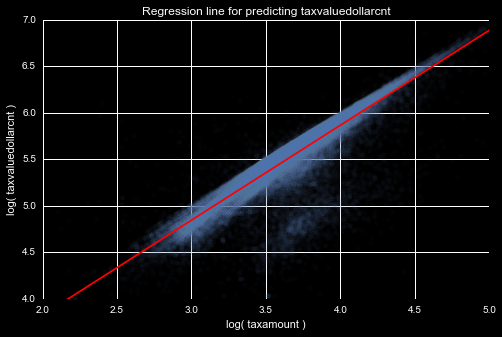

      taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  parcelid
1305           4.627694               4.627694        NaN  12973727
      taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  parcelid
1305           4.627694               4.627694   2.947924  12973727
 
       taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  parcelid
22541                NaN                    NaN   1.710963  17190827
       taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  parcelid
22541           3.529146               2.847406   1.710963  17190827
 
       taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  parcelid
34947           4.833784               4.833784        NaN  12917680
       taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  parcelid
34947           4.833784               4.833784   3.112076  12917680
 
       taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  parcelid
51225           5.253018               4.770204        NaN  12918603
       taxvaluedollarcnt  landta

In [45]:
def regression_taxamount( inp_df ):

    # get values, and log them
    foo = np.log10( inp_df[['taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount']] ).copy()
    foo['parcelid'] = inp_df['parcelid']
    
    # Bar is just not null values, for regression
    bar = foo.dropna()
    
        
    # Perform regressions
    land_reg = linear_model.LinearRegression()
    tax_reg  = linear_model.LinearRegression()
    amt_reg  = linear_model.LinearRegression()

    land_reg.fit( bar['taxamount'        ].to_frame(), bar['landtaxvaluedollarcnt'].to_frame() )
    tax_reg.fit ( bar['taxamount'        ].to_frame(), bar[    'taxvaluedollarcnt'].to_frame() )
    amt_reg.fit ( bar['taxvaluedollarcnt'].to_frame(), bar[            'taxamount'].to_frame() )

    
    print land_reg.coef_
    print land_reg.intercept_
    
    xx = np.array( [1,9] )
    foo.plot.scatter( y='landtaxvaluedollarcnt'    , x='taxamount', alpha=0.03, figsize=(8,5) )
    plt.plot( xx, land_reg.coef_[0]*xx + land_reg.intercept_, color='r' )
    plt.xlim(2.5,5)
    plt.ylim(3.5,7)
    plt.xlabel( 'log( taxamount )')
    plt.ylabel( 'log( landtaxvaluedollarcnt )')
    plt.title('Regression line for predicting landtaxvaluedollarcnt')
    plt.show()

    print tax_reg.coef_
    print tax_reg.intercept_
    
    xx = np.array( [1,9] )
    foo.plot.scatter( y='taxvaluedollarcnt'    , x='taxamount', alpha=0.03, figsize=(8,5) )    
    plt.plot( xx, tax_reg.coef_[0]*xx + tax_reg.intercept_, color='r' )
    plt.xlim(2,5)
    plt.ylim(4,7)
    plt.xlabel( 'log( taxamount )')
    plt.ylabel( 'log( taxvaluedollarcnt )')
    plt.title('Regression line for predicting taxvaluedollarcnt')
    plt.show()

    # Get the id numbers for the rows with NaN values
    for id_num in foo[ foo.isnull().any(axis=1) ]['parcelid'].values:
        
        # Find which row it is
        row_num = foo.loc[ foo['parcelid'] == id_num ].index

        print foo.loc[ row_num ]
        
        # Depending on what's missing, fill it in
        
        
        if( foo.ix[ row_num, 'landtaxvaluedollarcnt' ].isnull().values ):
            foo.ix[ row_num, 'landtaxvaluedollarcnt' ] = land_reg.predict( foo.ix[ row_num, 'taxamount'         ].values.reshape(-1,1) )
            
        if( foo.ix[ row_num,     'taxvaluedollarcnt' ].isnull().values ):
            foo.ix[ row_num,     'taxvaluedollarcnt' ] =  tax_reg.predict( foo.ix[ row_num, 'taxamount'         ].values.reshape(-1,1) )
            
        if( foo.ix[ row_num,             'taxamount' ].isnull().values ):
            foo.ix[ row_num,             'taxamount' ] =  amt_reg.predict( foo.ix[ row_num, 'taxvaluedollarcnt' ].values.reshape(-1,1) )
        print foo.loc[ row_num ]
        print ' '
            
        
            
regression_taxamount( my_df )

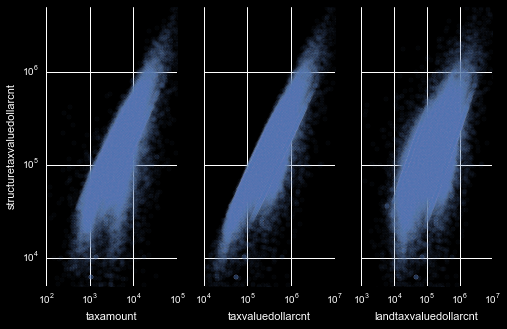

In [78]:
fig, axes = plt.subplots( 1, 3, figsize=(8,5) )

axes[0].set_xlim( [ 1e2 , 1e5 ] )
axes[1].set_xlim( [ 1e4 , 1e7 ] )
axes[2].set_xlim( [ 1e3 , 1e7 ] )

axes[0].set_ylim( [ 5e3 , 5e6 ] )
axes[1].set_ylim( [ 5e3 , 5e6 ] )
axes[2].set_ylim( [ 5e3 , 5e6 ] )


my_df.plot.scatter( x='taxamount'            , y='structuretaxvaluedollarcnt', alpha=0.05, logx=True, logy=True, ax = axes[0] )
my_df.plot.scatter( x='taxvaluedollarcnt'    , y='structuretaxvaluedollarcnt', alpha=0.05, logx=True, logy=True, ax = axes[1] )
my_df.plot.scatter( x='landtaxvaluedollarcnt', y='structuretaxvaluedollarcnt', alpha=0.05, logx=True, logy=True, ax = axes[2] )

axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

axes[1].set_ylabel('')
axes[2].set_ylabel('')

Can use these three values to predict structuretaxvaluedollarcnt

In [10]:
my_df[remain_list].isnull().sum().sort_values()

roomcnt                           0
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             1
taxamount                         6
structuretaxvaluedollarcnt      380
calculatedbathnbr              1182
unitcnt                       31922
numberofstories               69705
dtype: int64

In [23]:
for item in remain_list:
    print item
    print my_df[most_stuff].corrwith( my_df[item] ).sort_values()
    print ' '

calculatedbathnbr
time_since_built             -0.369543
building_quality_med         -0.172283
tax_delinquent               -0.033956
ordinal_date                 -0.005578
lot_sqft                      0.004853
day_of_week                   0.017949
logerror                      0.029448
roomcnt                       0.031486
has_deck                      0.043949
building_quality_unkn         0.045206
has_spa                       0.057994
has_pool                      0.073455
n_fireplaces                  0.100314
has_garage                    0.118644
unitcnt                       0.154641
building_quality_high         0.171318
garage_sqft                   0.193996
has_ac                        0.225834
pool_sqft                     0.254296
building_quality_low          0.257078
numberofstories               0.369760
landtaxvaluedollarcnt         0.371634
taxamount                     0.487320
taxvaluedollarcnt             0.497763
structuretaxvaluedollarcnt    0.611665
unit_sq

(0, 8)

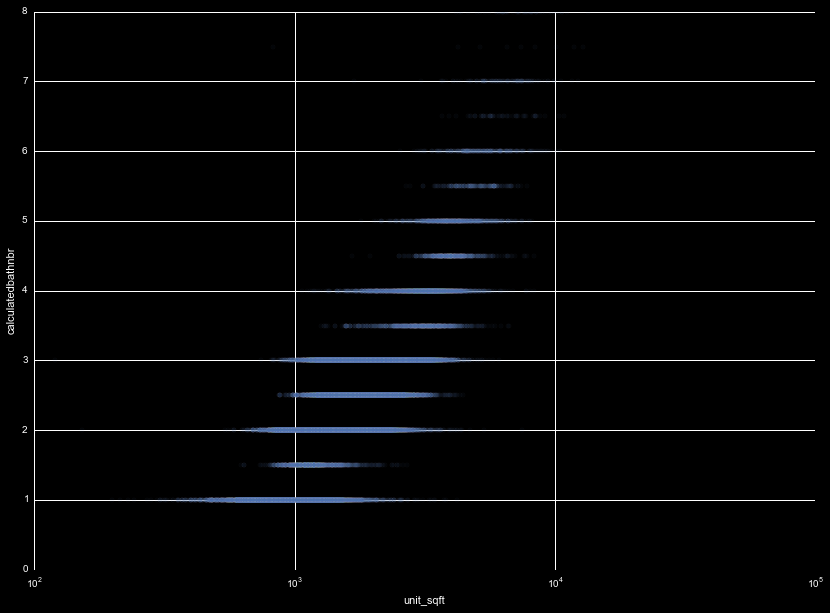

In [33]:
my_df.plot.scatter( x='unit_sqft', y='calculatedbathnbr', alpha=0.05 )
plt.xscale( 'log' )
plt.xlim( [1e2,1e5] )
plt.ylim( [  0,  8] )

(0, 10)

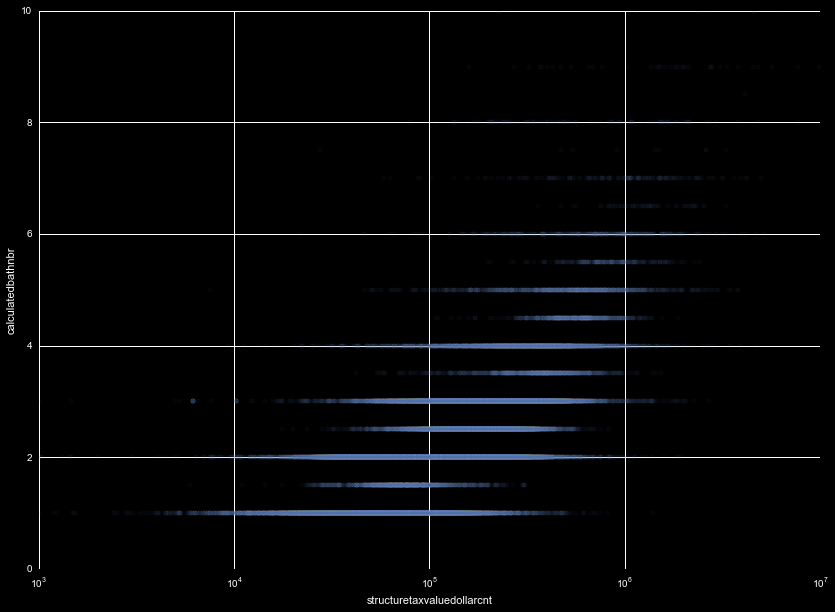

In [80]:
my_df.plot.scatter( x='structuretaxvaluedollarcnt', y='calculatedbathnbr', alpha=0.05 )
plt.xscale( 'log' )
plt.xlim( [1e3,1e7] )
plt.ylim( [  0,10 ] )

Possible to calculate bathnbr off these parameters, but lots of noise. maybe incorporate type of residence